#### Objective : 
    1. To define metrics to identify disengaged customers.Which will also include customer churned in that period
    2. Create a ML model to predict customers already churned 
    3. Defining a stratergy to target customers as soon as we identify them
#### Methodology :
    We will define the disengaged customers based on three metrics
        i. Customer who don't have single transaction in last 4 months 
        ii.Customers whose number of transaction are decreasing very month for continuously for 3 months
        iii.Customers whose transaction amount are decreasing very month for continuously for 3 months
    All the customers which qualify for any above metrics is considered as Disenageged customer
    It will be a imbalanced class problem so we need to deal with that also if we don't get a good model in first scenarios
    Also trying to understand which variables should be used as feature importance
    We will also play around with probability cutoffs to increase the recall by compromising on precision. As we want to      capture all the Users we will want a model which will have maximum recall. As cost of loosing a customer is always higher than sending coupons or cashback offers
#### Suggesting Next Steps : As all ideas can't be tried in limited time
#### Suggesting Required : Suggesting what would be deployment strategy for the model
#### Suggesting Steps to target about to churn customer with some stratergy

In [1]:
### Import all the required packages to be used for furthar analysis
import pandas as pd
import os
import numpy as np
import sklearn
import matplotlib.pyplot as plt
from IPython.display import display

In [2]:
### Change the locations for current working directory
os.getcwd()

'C:\\Users\\ash\\Desktop\\data_revolut'

In [3]:
### Read the file required and parse the datetime in the right format to be used further
mydateparser = lambda x: pd.datetime.strptime(x, "%Y-%m-%d %H:%M:%S.%f")
trans = pd.read_csv('C:\\Users\\ash\\Desktop\\data_revolut\\data\\rev-transactions.csv', parse_dates=['created_date'], date_parser=mydateparser)

In [4]:
### Print the statistics about the data read
print ("The shape of data is as follows :", trans.shape)
print ("Give the information on the data required :",trans.info())
print ("Describe the data :", trans.describe())
print ("Describe the data :",trans.describe(include ='object'))

The shape of data is as follows : (2740075, 12)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2740075 entries, 0 to 2740074
Data columns (total 12 columns):
transaction_id           object
transactions_type        object
transactions_currency    object
amount_usd               float64
transactions_state       object
ea_cardholderpresence    object
ea_merchant_mcc          float64
ea_merchant_city         object
ea_merchant_country      object
direction                object
user_id                  object
created_date             datetime64[ns]
dtypes: datetime64[ns](1), float64(2), object(9)
memory usage: 250.9+ MB
Give the information on the data required : None
Describe the data :          amount_usd  ea_merchant_mcc
count  2.740075e+06     1.581417e+06
mean   1.703225e+05     5.699736e+03
std    9.634014e+07     9.493660e+02
min    0.000000e+00     7.420000e+02
25%    2.030000e+00     5.411000e+03
50%    8.510000e+00     5.812000e+03
75%    2.822000e+01     5.921000e+03
max    

In [5]:
#### Extract the time related variables for datetime. Extract month, year and other variables to be summarized
trans['year'] = pd.DatetimeIndex(trans['created_date']).year
trans['quarter'] = pd.DatetimeIndex(trans['created_date']).quarter
trans['month'] = pd.DatetimeIndex(trans['created_date']).month
trans['year_quarter'] = trans['year'].astype(str) +  trans['quarter'].astype(str)
trans['month_year'] = trans['year'].astype(str) +  trans['month'].astype(str)

In [6]:
trans.head(5)

,transaction_id,transactions_type,transactions_currency,amount_usd,transactions_state,ea_cardholderpresence,ea_merchant_mcc,ea_merchant_city,ea_merchant_country,direction,user_id,created_date,year,quarter,month,year_quarter,month_year
0,transaction_0,TRANSFER,AED,4.55,COMPLETED,NaN,NaN,NaN,NaN,OUTBOUND,user_898,2018-04-03 03:34:21.784487,2018,2,4,20182,20184
1,transaction_1,CARD_PAYMENT,AED,15.50,COMPLETED,FALSE,4111.0,Dubai,ARE,OUTBOUND,user_1652,2019-03-19 06:15:59.537032,2019,1,3,20191,20193
2,transaction_2,CARD_PAYMENT,AED,43.40,COMPLETED,FALSE,5814.0,Dubai,ARE,OUTBOUND,user_1652,2019-03-18 18:53:41.323032,2019,1,3,20191,20193
3,transaction_3,TRANSFER,AED,10043.01,COMPLETED,NaN,NaN,NaN,NaN,OUTBOUND,user_1652,2019-03-22 14:20:01.513032,2019,1,3,20191,20193
4,transaction_4,CARD_PAYMENT,AED,43.81,COMPLETED,FALSE,5651.0,Abu Dhabi,ARE,OUTBOUND,user_5509,2019-03-22 05:42:50.316652,2019,1,3,20191,20193


#### Lets only consider transaction which have following transactions so that we exclude incompleted transactions

In [7]:
print ("Transactions with all transaction irrespective of transaction state",trans.shape)
trans_comp = trans[trans['transactions_state'] == 'COMPLETED']
print ("Transactions with only transaction state",trans_comp.shape)

Transactions with all transaction irrespective of transaction state (2740075, 17)
Transactions with only transaction state (2407968, 17)


In [8]:
### Look at the distribution of transactions type after filtering out transactions state is completed
trans_comp['transactions_type'].value_counts()

CARD_PAYMENT    1257461
TRANSFER         493168
TOPUP            303750
EXCHANGE         159146
ATM               77824
CASHBACK          76713
FEE               23659
CARD_REFUND       11960
TAX                2794
REFUND             1493
Name: transactions_type, dtype: int64

### Lets Only consider the transactions which have customer did intentionally so we will remove folllwing transactions type
1. FEE
2. CARD_REFUND
3. TAX
4. REFUND

In [9]:
trans_analysis= trans_comp[~trans_comp['transactions_type'].isin(['FEE','CARD_REFUND','TAX','REFUND'])]
print ("Shape of transaction data after filetring is :",trans_analysis.shape)

Shape of transaction data after filetring is : (2368062, 17)


### Lets summarize the data by transaction month by user id
### To create following varables at month level
##### 1. Sum of USD Transactions Amount
##### 2. Number of Transactions in a Month
##### 3. Number of distinct cities where transactions was done
##### 4. Number of ditinct merchants on which transactions is done
##### 5. Number of distinct  types of transactions

In [10]:
##Step 1: Group by User Id and Months as we will be used in Further analysis. 
### If we had time we will also want to add variables summary at quarter level
groupby1 = trans_analysis.groupby(['user_id','month_year'])

##Step 2: Calculate different aggregations to create variables defined above
trans_count = groupby1['transaction_id'].count()
amt_sum = groupby1['amount_usd'].sum()
dist_currency = groupby1['transactions_currency'].nunique()
dist_city = groupby1['ea_merchant_city'].nunique()
dist_country = groupby1['ea_merchant_country'].nunique()
dist_trans =  groupby1['transactions_type'].nunique()


##Step 3: Combine into a single DataFrame
trans_sum = pd.DataFrame({'trans_count':trans_count,'amt_sum':amt_sum,'dist_currency':dist_currency,'dist_city':dist_city,
                          'dist_country':dist_country,'dist_trans':dist_trans}).reset_index()

In [11]:
### Group by always creates dataframes by hierarchical Index and columns names
### In below steps we will change them to the normal dataframes with non-hierarchical index
trans1 = trans_sum.set_index(['user_id', 'month_year'])
trans2 = trans1.unstack(level =1)

In [12]:
### Join the levels to create alist of columns names in list and assign it to columm names
new_cols = [''.join(t) for t in trans2.columns]
print ("The number of columns post aggreagtion is :",len(new_cols))
trans2.columns = new_cols
trans2 =trans2.reset_index()

The number of columns post aggreagtion is : 102


In [13]:
print ("Have alook at the data and check if its aligned with expectation i.e. Non Hierachical index")
trans2.head(4)

Have alook at the data and check if its aligned with expectation i.e. Non Hierachical index


,user_id,trans_count20181,trans_count201810,trans_count201811,trans_count201812,trans_count20182,trans_count20183,trans_count20184,trans_count20185,trans_count20186,...,dist_trans20185,dist_trans20186,dist_trans20187,dist_trans20188,dist_trans20189,dist_trans20191,dist_trans20192,dist_trans20193,dist_trans20194,dist_trans20195
0,user_0,14.0,23.0,10.0,9.0,13.0,41.0,12.0,18.0,26.0,...,3.0,4.0,4.0,4.0,4.0,2.0,4.0,4.0,5.0,2.0
1,user_1,1.0,NaN,9.0,8.0,NaN,9.0,29.0,7.0,14.0,...,3.0,3.0,3.0,3.0,2.0,2.0,3.0,NaN,NaN,NaN
2,user_10,22.0,90.0,65.0,69.0,45.0,35.0,43.0,38.0,42.0,...,4.0,4.0,4.0,4.0,3.0,4.0,2.0,4.0,4.0,3.0
3,user_100,1.0,4.0,NaN,NaN,5.0,7.0,6.0,NaN,NaN,...,NaN,NaN,2.0,2.0,2.0,2.0,3.0,3.0,3.0,2.0


#### In this data missing values means that they have no trasaction in that month. Replace it with zeroes

In [14]:
trans2 = trans2.fillna(0)

#### Customer at risk or disnegaged would have transaction amount going down for 3 months continuoulsy

In [15]:
risky_avg_transaction = []
for idx,row in trans2.iterrows():
    if  (row['amt_sum20191'] > row['amt_sum20192']) & (row['amt_sum20192'] > row['amt_sum20193']) & (row['amt_sum20193'] > row['amt_sum20194']):
        risky_avg_transaction.append(idx)
        
print (len(risky_avg_transaction))

trans2['risky_by_avg_tran'] = np.where(trans2.index.isin(risky_avg_transaction),1,0)


513


#### Customer at risk flag or disnegaged for customers whose transaction count is going down month by month for 201902 to 201904

In [16]:
risky_count_transaction = []
for idx,row in trans2.iterrows():
    if  (row['trans_count20191'] > row['trans_count20192']) & (row['trans_count20192'] > row['trans_count20193']) & (row['trans_count20193'] > row['trans_count20194']):
        risky_count_transaction.append(idx)
        
print (len(risky_count_transaction))

trans2['risky_by_count_tran'] = np.where(trans2.index.isin(risky_count_transaction),1,0)

397


#### Customer at risk flag or disengaged for customers who have no transaction in last 3 months but are associated for longer tahn 3 months

In [17]:
risky_no_transaction = []
for idx,row in trans2.iterrows():
    if  (row['trans_count20191'] == 0) & (row['trans_count20192'] ==0) & (row['trans_count20193'] == 0) & (row['trans_count20194'] == 0) & (row['trans_count201812'] > 0)  :
        risky_no_transaction.append(idx)
        
print (len(risky_no_transaction))

trans2['risky_by_no_transaction'] = np.where(trans2.index.isin(risky_no_transaction),1,0)

816


### Create target varibles for model by combining three flags created before

In [18]:

trans2['target'] = trans2.apply(lambda x: 1 if (x.risky_by_no_transaction==1) or (x.risky_by_count_tran==1) or (x.risky_by_avg_tran == 1)  else 0,axis=1)
target = trans2["target"].value_counts()
target

0    16937
1     1559
Name: target, dtype: int64

### Define the variable list to be used in model along with the target variables

In [19]:
model_variables_list = ["user_id","trans_count20181","trans_count201810","trans_count201811","trans_count201812","trans_count20182","trans_count20183","trans_count20184","trans_count20185","trans_count20186","trans_count20187","trans_count20188","trans_count20189","amt_sum20181","amt_sum201810","amt_sum201811","amt_sum201812","amt_sum20182","amt_sum20183","amt_sum20184","amt_sum20185","amt_sum20186","amt_sum20187","amt_sum20188","amt_sum20189","dist_currency20181","dist_currency201810","dist_currency201811","dist_currency201812","dist_currency20182","dist_currency20183","dist_currency20184","dist_currency20185","dist_currency20186","dist_currency20187","dist_currency20188","dist_currency20189","dist_city20181","dist_city201810","dist_city201811","dist_city201812","dist_city20182","dist_city20183","dist_city20184","dist_city20185","dist_city20186","dist_city20187","dist_city20188","dist_city20189","dist_country20181","dist_country201810","dist_country201811","dist_country201812","dist_country20182","dist_country20183","dist_country20184","dist_country20185","dist_country20186","dist_country20187","dist_country20188","dist_country20189","dist_trans20181","dist_trans201810","dist_trans201811","dist_trans201812","dist_trans20182","dist_trans20183"
                        ,"dist_trans20184","dist_trans20185","dist_trans20186","dist_trans20187","dist_trans20188","dist_trans20189","target"]

model_df =trans2[model_variables_list]

In [20]:
### Now model df has all the variables which we need for further analysis
### Get in the demographics variables of user

In [21]:
users_data = pd.read_csv(('C:\\Users\\ash\\Desktop\\data_revolut\\data\\rev-users.csv'))
print ("Shape of users data is",users_data.shape)
print (users_data['user_id'].nunique())

Shape of users data is (19430, 12)
19430


In [22]:
## As we have distinct user id it is safe to join it to users table
print ("Shape of model data before merge is",model_df.shape)
model_df = pd.merge(model_df,users_data,how = 'inner',on = 'user_id')
print ("Shape of model data after merge is ", model_df.shape)

Shape of model data before merge is (18496, 74)
Shape of model data after merge is  (18496, 85)


In [23]:
### Get in the device usage of users 
users_device = pd.read_csv(('C:\\Users\\ash\\Desktop\\data_revolut\\data\\rev-devices.csv'))
print ("Shape of users data is",users_device.shape)
print (users_device['user_id'].nunique())

Shape of users data is (19430, 2)
19430


In [24]:
## As we have distinct user id it is safe to join it to users table
print ("Shape of model data before merge is",model_df.shape)
model_df = pd.merge(model_df,users_device,how = 'inner',on = 'user_id')
print ("Shape of model data after merge is ", model_df.shape)

Shape of model data before merge is (18496, 85)
Shape of model data after merge is  (18496, 86)


In [25]:
### Drop the variables you don't want to use right now
### referrals as it has all zero values and country and city as they would have lots of level which we dont hae time to deal with
drop_var = ['country','city','num_referrals','num_successful_referrals']
model_df.drop(drop_var,inplace = True, axis = 1)
model_df.shape

(18496, 82)

In [26]:
### Lets do some feature engineering on other variables 
### Convert the Birth year into age groups
bins = [0,25, 35, 50, 59,60]
labels = ['less_25', '25-35', '35-50', '50-59', '60+']
model_df['agerange'] = pd.cut(2020 - model_df['birth_year'], bins, labels = labels,include_lowest = True)
model_df.drop(['birth_year'],axis = 1, inplace = True)

In [27]:
### Lets create some features on User Create year 
### We will exlude customer which have joined after 2018 actober as we will not ahve much transaction data for them
import datetime
model_df['days_joined'] = (datetime.date(2018, 10, 31) - pd.DatetimeIndex(model_df['created_date']).date)
model_df['days_joined'] = model_df['days_joined'] / np.timedelta64(1, 'D')

In [28]:
### Exclude all the custoemr from analysis which ahve joined after october 31
model_df = model_df[model_df['days_joined']>0]

In [29]:
### Create variable on joining date as reqired
bins = [0,30, 90, 180,999]
labels = ['less_month', 'month_quarter', 'quarter_halfyear', 'more_halfyear']
model_df['joinedrange'] = pd.cut(model_df['days_joined'], bins, labels = labels,include_lowest = True)
model_df.drop(['days_joined','created_date'],axis = 1, inplace = True)

In [30]:
### Our data is ready for modelling
model_df.shape

(14374, 82)

### Convert the categorical varible to one hot dummy encoding

In [31]:
cat_variables_list = ['plan','brand','agerange','joinedrange','attributes_notifications_marketing_push',
'attributes_notifications_marketing_email','user_settings_crypto_unlocked']

In [32]:
model_data = pd.get_dummies(model_df,columns = cat_variables_list)
print ("Number of variable after dummy treatments is",model_data.shape)
print ("Columns are as follow",model_data.columns)

Number of variable after dummy treatments is (14374, 99)
Columns are as follow Index(['user_id', 'trans_count20181', 'trans_count201810', 'trans_count201811',
       'trans_count201812', 'trans_count20182', 'trans_count20183',
       'trans_count20184', 'trans_count20185', 'trans_count20186',
       'trans_count20187', 'trans_count20188', 'trans_count20189',
       'amt_sum20181', 'amt_sum201810', 'amt_sum201811', 'amt_sum201812',
       'amt_sum20182', 'amt_sum20183', 'amt_sum20184', 'amt_sum20185',
       'amt_sum20186', 'amt_sum20187', 'amt_sum20188', 'amt_sum20189',
       'dist_currency20181', 'dist_currency201810', 'dist_currency201811',
       'dist_currency201812', 'dist_currency20182', 'dist_currency20183',
       'dist_currency20184', 'dist_currency20185', 'dist_currency20186',
       'dist_currency20187', 'dist_currency20188', 'dist_currency20189',
       'dist_city20181', 'dist_city201810', 'dist_city201811',
       'dist_city201812', 'dist_city20182', 'dist_city20183', 'di

In [33]:
#### Create the target variable and delete unnecessary columns
# target = model_data["target"]
model_data.drop(['user_id'],inplace=True,axis=1)
model_data.head()

,trans_count20181,trans_count201810,trans_count201811,trans_count201812,trans_count20182,trans_count20183,trans_count20184,trans_count20185,trans_count20186,trans_count20187,...,joinedrange_less_month,joinedrange_month_quarter,joinedrange_quarter_halfyear,joinedrange_more_halfyear,attributes_notifications_marketing_push_0.0,attributes_notifications_marketing_push_1.0,attributes_notifications_marketing_email_0.0,attributes_notifications_marketing_email_1.0,user_settings_crypto_unlocked_0,user_settings_crypto_unlocked_1
0,14.0,23.0,10.0,9.0,13.0,41.0,12.0,18.0,26.0,44.0,...,0,0,0,1,0,1,0,1,0,1
1,1.0,0.0,9.0,8.0,0.0,9.0,29.0,7.0,14.0,5.0,...,0,0,0,1,0,0,0,0,1,0
2,22.0,90.0,65.0,69.0,45.0,35.0,43.0,38.0,42.0,40.0,...,0,0,0,1,0,1,0,1,1,0
3,1.0,4.0,0.0,0.0,5.0,7.0,6.0,0.0,0.0,18.0,...,0,0,0,1,0,0,0,0,1,0
4,21.0,0.0,0.0,0.0,7.0,6.0,0.0,0.0,1.0,0.0,...,0,0,0,1,0,1,0,1,0,1


In [34]:
### Work on balancing as nothing else worked

In [35]:
target1 = len(model_data[model_data['target'] == 1]) * 2
target0 = model_data[model_data.target == 0].index
random_indices = np.random.choice(target0,target1 , replace=False)
target1 = model_data[model_data['target']==1].index
under_sample_indices = np.concatenate([target1,random_indices])
under_sample = model_data.loc[under_sample_indices]

In [36]:
under_sample['target'].value_counts()

0    2008
1    1004
Name: target, dtype: int64

In [37]:
target = under_sample['target']
under_sample.drop(['target'],inplace=True,axis=1)
under_sample.head()

,trans_count20181,trans_count201810,trans_count201811,trans_count201812,trans_count20182,trans_count20183,trans_count20184,trans_count20185,trans_count20186,trans_count20187,...,joinedrange_less_month,joinedrange_month_quarter,joinedrange_quarter_halfyear,joinedrange_more_halfyear,attributes_notifications_marketing_push_0.0,attributes_notifications_marketing_push_1.0,attributes_notifications_marketing_email_0.0,attributes_notifications_marketing_email_1.0,user_settings_crypto_unlocked_0,user_settings_crypto_unlocked_1
9,0.0,5.0,24.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,1,0,0,0,1,0,1,1,0
10,0.0,5.0,0.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,1,0,0,0,0,0,0,1,0
24,0.0,85.0,202.0,55.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,1,0,0,0,1,0,1,1,0
25,2.0,13.0,20.0,11.0,2.0,2.0,4.0,10.0,12.0,29.0,...,0,0,0,1,0,0,0,0,1,0
35,0.0,2.0,33.0,120.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,1,0,0,0,1,0,1,0,1


In [38]:
from sklearn.model_selection import train_test_split
# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(under_sample, 
                                                    target, 
                                                    test_size = 0.2, 
                                                    random_state = 0,stratify = target)

# Show the results of the split
print ("Training set has  samples", X_train.shape[0])
print ("Testing set has  samples  ",X_test.shape[0])

Training set has  samples 2409
Testing set has  samples   603


In [39]:
### Create a simple & dumb base line model 

In [40]:
### Base Line Model : If our model predicted everything as Risky
TP = np.sum(target) # Counting the ones as this is the naive case. 

FP = target.count() - TP # Specific to the naive case

TN = 0 # No predicted negatives in the naive case
FN = 0 # No predicted negatives in the naive case
print (TP,FP)
# TODO: Calculate accuracy, precision and recall

accuracy = float(TP)/float(target.count())
recall = 1
precision = accuracy
beta= 0.5


# The formula for fbeta score can be written as (1 + beta**2) * (precision * recall) / ((beta**2 * precision) + recall)
fscore = (1 + 0.25) * (precision * recall) / ((0.25 * precision) + recall)

# Print the results 
print ("Naive Predictor: [Accuracy score: {:.4f}, F-score: {:.4f}]".format(accuracy, fscore))

1004 2008
Naive Predictor: [Accuracy score: 0.3333, F-score: 0.3846]


In [41]:
### Building a train predictor to compare multiple models¶
### Here metrics that I am going to use to compare different models is F1 score, accuracy
### More prefrence give  to F score as it is imbalanced class problem
from sklearn.metrics import fbeta_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import make_scorer, precision_recall_curve,confusion_matrix
from sklearn import  metrics

import time
def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 

    results = {}
    
  
    start = time.time()
    learner = learner.fit(X_train[:sample_size], y_train[:sample_size])
    end = time.time()
    
    results['train_time'] = end - start
    
    start = time.time()
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train)
    end = time.time()
    
    results['pred_time'] = end - start
    results['acc_train'] = accuracy_score(y_train, predictions_train)
        
    results['acc_test'] = accuracy_score(y_test, predictions_test)
    
    results['f_train'] = fbeta_score(y_train, predictions_train, 0.5,average='weighted')
        
    results['f_test'] = fbeta_score(y_test, predictions_test, 0.5,average='weighted')
    matrix =  confusion_matrix(y_test, predictions_test)
    TP =  matrix[0][0]
    FP = matrix[0][1]  # Specific to the naive case

    TN = matrix[1][1] # No predicted negatives in the naive case
    FN = matrix[1][0] # No predicted negatives in the naive case

    # TODO: Calculate accuracy, precision and recall
    accuracy = metrics.accuracy_score(y_test, predictions_test)
    recall = float(TP )/  float(TP + FN)
    precision = float(TP )/ float(TP + FP)
    #print "precision: {}, recall: {}".format(recall, precision) 
    beta = 0.5
    
    # TODO: Calculate F-score using the formula above for beta = 0.5 and correct values for precision and recall.
    # HINT: The formula above can be written as (1 + beta**2) * (precision * recall) / ((beta**2 * precision) + recall)
    fscore = (1 + 0.25) * (precision * recall) / ((0.25 * precision) + recall)
    print ("Test fscore with beta 0.5 : ", fscore )  
    print ("{} trained on {} samples.".format(learner.__class__.__name__, sample_size))
    dataframe = pd.DataFrame(predictions_train,y_train)  
    dataframe.to_csv(learner.__class__.__name__+".txt")
    # Return the results
    return results

### Try out various classification model and use one of the best model for tuning

In [42]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import linear_model
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
import warnings
warnings.filterwarnings("ignore")

# TODO: Initialize the three models
clf_A =  linear_model.LogisticRegressionCV(solver='lbfgs',random_state=40)
clf_B = KNeighborsClassifier()
clf_C = RandomForestClassifier(random_state=40)
#clf_D = RandomForestClassifier(random_state = 40)

samples_100 = len(y_train)
samples_10 = int(samples_100 * 0.1)
samples_1 = int(samples_100 * 0.01)

# Collect results on the learners
results = {}
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1,samples_10,samples_100]):
        results[clf_name][i]=train_predict(clf, samples, X_train, y_train, X_test, y_test)



Test fscore with beta 0.5 :  0.8430097538318626
LogisticRegressionCV trained on 24 samples.
Test fscore with beta 0.5 :  0.7440039158100832
LogisticRegressionCV trained on 240 samples.
Test fscore with beta 0.5 :  0.8735632183908046
LogisticRegressionCV trained on 2409 samples.
Test fscore with beta 0.5 :  0.9037238873751136
KNeighborsClassifier trained on 24 samples.
Test fscore with beta 0.5 :  0.7414634146341463
KNeighborsClassifier trained on 240 samples.
Test fscore with beta 0.5 :  0.7898516036381044
KNeighborsClassifier trained on 2409 samples.
Test fscore with beta 0.5 :  0.8372310570626753
RandomForestClassifier trained on 24 samples.
Test fscore with beta 0.5 :  0.7041540020263424
RandomForestClassifier trained on 240 samples.
Test fscore with beta 0.5 :  0.8353394318728937
RandomForestClassifier trained on 2409 samples.


#### Random forest and K nearest are the best models. But we will use Random forest as it is faster and scalable on bigger data also
#### We will try to use Gridsearch cv to do some hyperparamter tuning on random forest 

In [44]:
# Import 'GridSearchCV', 'make_scorer', and any other necessary libraries
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import classification_report

from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [200,400,600,800,1000]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(2, 10, num = 1)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10,20,50]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4,8,12,20,40]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf =  RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 50, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)
print (rf_random.best_params_)
# Make predictions using the unoptimized and model
best_random = rf_random.best_estimator_

# predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_random.predict(X_test)

# Report the before-and-afterscores

print ("\nOptimized Model\n------")
# print ("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions )))
# print ("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions , beta = 0.5,average='weighted')))
print(classification_report(y_test, best_predictions))

{'n_estimators': [200, 400, 600, 800, 1000], 'max_features': ['auto', 'sqrt'], 'max_depth': [2, None], 'min_samples_split': [2, 5, 10, 20, 50], 'min_samples_leaf': [1, 2, 4, 8, 12, 20, 40], 'bootstrap': [True, False]}

Optimized Model
------
              precision    recall  f1-score   support

           0       0.72      0.92      0.81       402
           1       0.65      0.28      0.39       201

    accuracy                           0.71       603
   macro avg       0.68      0.60      0.60       603
weighted avg       0.70      0.71      0.67       603



### We are doing better than first draft of model let fine tune

Using balanced RandomForestClassifier approach:
Weights are inversely proportional with the frequency of class observaton:
                                            
                                            wj=nj / knj
 
where  wj  is the weight to class  j ,  n  is the number of observations,  nj  is the number of observations in class  j 
, and  k  is the total number of classes. In our case, that indicates that the minority class label (fraud) should be 
weighted higher.

In [47]:

from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [200,400,600,800,1000]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [4,5,6,7,8,9,10]

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10,20,50]
# Minimum number of samples required at each leaf node
min_samples_leaf = [4,8,12,20,40]
# Method of selecting samples for training each tree
bootstrap = [True, False]
class_weight = ['balanced','balanced_subsample']
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
               'class_weight':class_weight
              }
print(random_grid)

# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf =  RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 500, cv = 2, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)
print (rf_random.best_params_)
# Make predictions using the unoptimized and model
best_random = rf_random.best_estimator_

# predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_random.predict(X_test)

# Report the before-and-afterscores

print ("\nOptimized Model\n------")
# print ("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions )))
# print ("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions , beta = 0.5,average='weighted')))
print(classification_report(y_test, best_predictions))

{'n_estimators': [200, 400, 600, 800, 1000], 'max_features': ['auto', 'sqrt'], 'max_depth': [4, 5, 6, 7, 8, 9, 10], 'min_samples_split': [2, 5, 10, 20, 50], 'min_samples_leaf': [4, 8, 12, 20, 40], 'bootstrap': [True, False], 'class_weight': ['balanced', 'balanced_subsample']}

Optimized Model
------
              precision    recall  f1-score   support

           0       0.84      0.57      0.68       402
           1       0.48      0.79      0.60       201

    accuracy                           0.64       603
   macro avg       0.66      0.68      0.64       603
weighted avg       0.72      0.64      0.65       603



Feature ranking:
1. feature amt_sum201812 (0.121308)
2. feature trans_count201812 (0.101498)
3. feature dist_trans201812 (0.098876)
4. feature dist_currency201812 (0.096600)
5. feature num_contacts (0.039067)
6. feature dist_city201812 (0.029899)
7. feature dist_country201812 (0.029831)
8. feature amt_sum201811 (0.025613)
9. feature amt_sum201810 (0.021535)
10. feature trans_count201811 (0.021101)
11. feature amt_sum20189 (0.017929)
12. feature amt_sum20188 (0.017550)
13. feature trans_count201810 (0.017325)
14. feature trans_count20189 (0.015397)
15. feature dist_city201811 (0.014307)
16. feature amt_sum20187 (0.014156)
17. feature dist_trans201811 (0.013952)
18. feature trans_count20188 (0.013471)
19. feature trans_count20187 (0.012217)
20. feature dist_city201810 (0.011257)
21. feature amt_sum20186 (0.010478)
22. feature trans_count20186 (0.009623)
23. feature dist_currency201811 (0.009277)
24. feature dist_city20188 (0.009258)
25. feature dist_trans201810 (0.008923)
26. feature dis

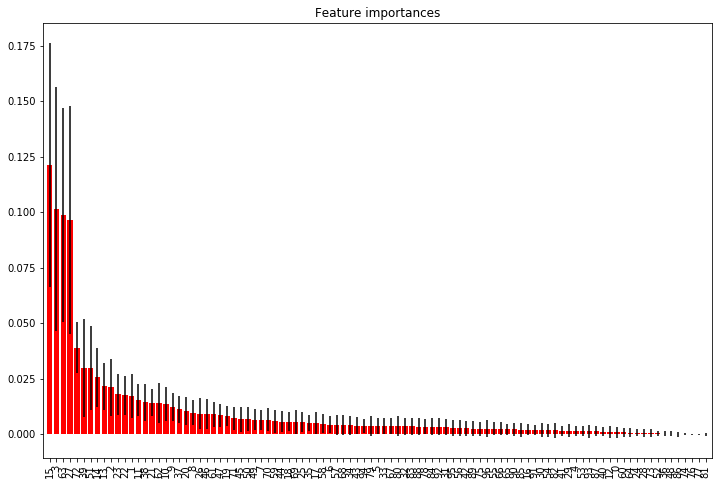

In [48]:
importances = best_random.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]
probabilities = clf.predict_proba(X_test)[:, 1]
print("Feature ranking:")

for f in range(X_train.shape[1]):
    print("%d. feature %s (%f)" % (f + 1, X_train.columns[indices[f]], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure(figsize=(12,8))
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X_train.shape[1]), indices)
plt.xlim([-1, X_train.shape[1]])
plt.xticks(rotation='vertical')
plt.show()

### Next Steps on improving the model

1. Try More Sampling Technique like SMOTE, UPSAMPLING, TOMEK LINKS
2. Add new features from Notifications, mainly days to last notifications received, number of notifications received
3. Try More advanced Boosting techniques like XGBoost with class weights 
4. Try to create more feature based on quarters and weekly summarization
5. Play around with ROC curve to find best Recall as loosing a customer is higher cost than sending wrong notifications

### Deployment Tips:
1. Save the best model as pickle file
2. Change the variable names from month indicator to t0 to t11 , where t0 is oldest month and t11 is latest month. 
3. If you want to predict for next month change all condition by moving a month forward that is t0 will ove from 20181 to 20182 
4. Automate the complete data creation process and just predict


### Steps to be taken for identified customers
1. Send them offer for cash back or anyother offer whch increases their engagemnt
2. Send them offer of merchant they have done most transactions in the past
3. Calls to understand if they are facing any issues and revolut can help them solve it
4. Offering them free upgrades